# Thomas Jones - CS5530-0005 - Final Project

## Common Imports

In [266]:
#analysis imports
import pandas as pd

#visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

#dataload imports
import requests
import io

## Task 1 - Laptop Regression

### Dataload (Data Gathering)
Load the laptop csv

In [267]:

# # Load your dataset
url = 'https://raw.githubusercontent.com/wortcook/UMKC/refs/heads/main/Fall2024/CS5530-0005/proj/laptop_prices.csv'
s = requests.get(url).content
df_laptops = pd.read_csv(io.StringIO(s.decode('utf-8')))
df_laptops.head()

,Company,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,ScreenH,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
0,Apple,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,1600,...,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,900,...,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,1080,...,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620
3,Apple,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,1800,...,Yes,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
4,Apple,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,1600,...,Yes,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650


### Data Cleaning

We will first take a look at the overall data to get a sense of the types and any missing values.

In [268]:
print(df_laptops.info())
print(df_laptops.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1275 non-null   object 
 1   TypeName              1275 non-null   object 
 2   Inches                1275 non-null   float64
 3   Ram                   1275 non-null   int64  
 4   OS                    1275 non-null   object 
 5   Weight                1275 non-null   float64
 6   Price_euros           1271 non-null   float64
 7   Screen                1275 non-null   object 
 8   ScreenW               1275 non-null   int64  
 9   ScreenH               1275 non-null   int64  
 10  Touchscreen           1275 non-null   object 
 11  IPSpanel              1275 non-null   object 
 12  RetinaDisplay         1273 non-null   object 
 13  CPU_company           1275 non-null   object 
 14  CPU_freq              1274 non-null   float64
 15  CPU_model            

#### Data Cleaning Discussion
Since price is our target variable it does not make sense to impute those. Those entries should be dropped.

For RetinaDisplay, it is reasonable to assume that missing data means "no" so for those values we will use default values.

There is only a single value missing for CPU Frequency, as this is not significant compared to the total data size we will remove that row.

In [269]:
# Remove rows with missing Price_euros
df_laptops.dropna(subset=['Price_euros'], inplace=True)

# Fill missing values for RetinaDisplay with 'No'
df_laptops.fillna({'RetinaDisplay': 'No'}, inplace=True)

# Remove rows with missing CPU_freq
df_laptops.dropna(subset=['CPU_freq'], inplace=True)

# Finally, remove rows with missing values remaining
print(df_laptops.isna().sum())

Company                 0
TypeName                0
Inches                  0
Ram                     0
OS                      0
Weight                  0
Price_euros             0
Screen                  0
ScreenW                 0
ScreenH                 0
Touchscreen             0
IPSpanel                0
RetinaDisplay           0
CPU_company             0
CPU_freq                0
CPU_model               0
PrimaryStorage          0
SecondaryStorage        0
PrimaryStorageType      0
SecondaryStorageType    0
GPU_company             0
GPU_model               0
dtype: int64


### Data Exploration
The laptop data contains a mix of category and numerical data. We'll start with the category data first to get an idea of what values are present for each category. To do this, we'll first split out the category columns.

In [270]:
#list out the cateogory columns, will be useful later
laptop_category_columns = ['Company', 'TypeName', 'OS', 'Screen', 'Touchscreen', 'RetinaDisplay', 
                           'CPU_company', 'CPU_model', 'PrimaryStorageType', 'SecondaryStorageType', 'GPU_company', 'GPU_model']

df_laptop_category_data = df_laptops[laptop_category_columns]

df_laptop_unique_category_values = df_laptop_category_data.nunique()

print(df_laptop_unique_category_values)


Company                  19
TypeName                  6
OS                        9
Screen                    4
Touchscreen               3
RetinaDisplay             2
CPU_company               3
CPU_model                93
PrimaryStorageType        4
SecondaryStorageType      4
GPU_company               4
GPU_model               110
dtype: int64


One thing to notice is the large differences in counts of different types of CPUs and GPUs. These may be useful for predictive analysis later but that data won't fit very well on bar charts. It may be that there are a few types that dominate the counts, however, so we can evaluate them.

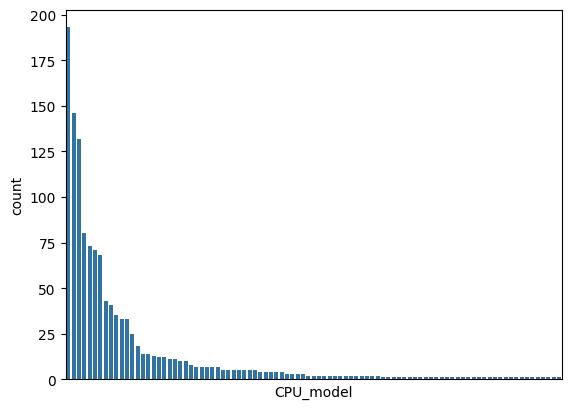

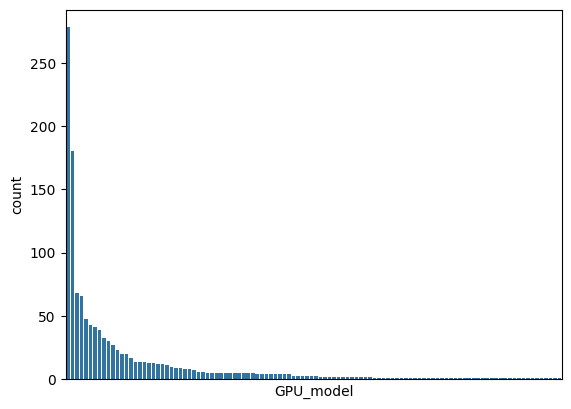

In [271]:
#Plot the most common CPU models
sns.countplot(data=df_laptops, x='CPU_model', order=df_laptops['CPU_model'].value_counts().index)
plt.xticks([])
plt.show()

sns.countplot(data=df_laptops, x='GPU_model', order=df_laptops['GPU_model'].value_counts().index)
plt.xticks([])
plt.show()


For the plot above we can see that there are a large number of CPU and GPU models that exist on the tails of the plots, i.e. there are a large number that have only a few values. We can group those together into an "other" category. This will allow us to utilize the model as a predictive characteristic for the more common cases.

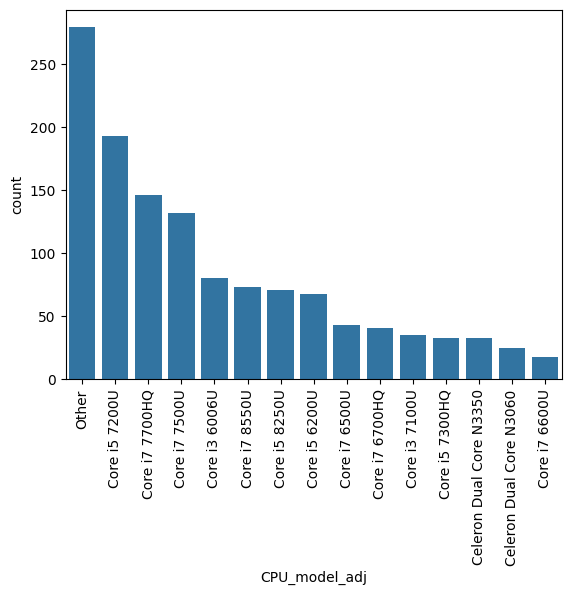

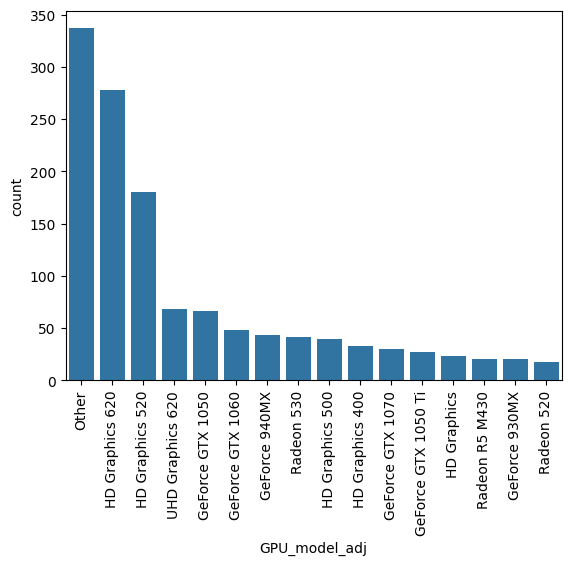

In [272]:
#Now we are going to create two new columns where any CPU/GPU model that appears less than 15 times will be replaced with 'Other'
df_laptops['CPU_model_adj'] = df_laptops['CPU_model'].apply(lambda x: x if df_laptops['CPU_model'].value_counts()[x] > 15 else 'Other')
df_laptops['GPU_model_adj'] = df_laptops['GPU_model'].apply(lambda x: x if df_laptops['GPU_model'].value_counts()[x] > 15 else 'Other')

#Now replot the CPU/GPU models
sns.countplot(data=df_laptops, x='CPU_model_adj', order=df_laptops['CPU_model_adj'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

sns.countplot(data=df_laptops, x='GPU_model_adj', order=df_laptops['GPU_model_adj'].value_counts().index)
plt.xticks(rotation=90)
plt.show()


Company                 19
TypeName                 6
OS                       9
Screen                   4
Touchscreen              3
RetinaDisplay            2
CPU_company              3
CPU_model_adj           15
PrimaryStorageType       4
SecondaryStorageType     4
GPU_company              4
GPU_model_adj           16
dtype: int64


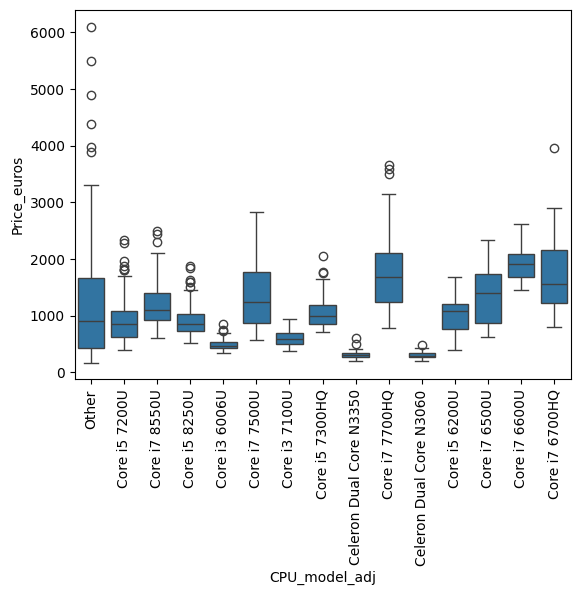

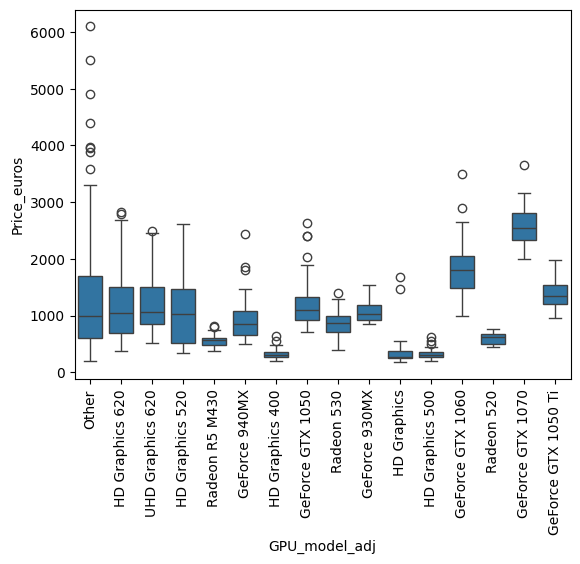

In [273]:
#Check our counts again
laptop_category_columns = ['Company', 'TypeName', 'OS', 'Screen', 'Touchscreen', 'RetinaDisplay', 
                           'CPU_company', 'CPU_model_adj', 'PrimaryStorageType', 'SecondaryStorageType', 'GPU_company', 'GPU_model_adj']

df_laptop_category_data = df_laptops[laptop_category_columns]

df_laptop_unique_category_values = df_laptop_category_data.nunique()

print(df_laptop_unique_category_values)

#Finally, let's look at the price data for the laptops for CPU and GPU models
sns.boxplot(data=df_laptops, x='CPU_model_adj', y='Price_euros')
plt.xticks(rotation=90)
plt.show()

sns.boxplot(data=df_laptops, x='GPU_model_adj', y='Price_euros')
plt.xticks(rotation=90)
plt.show()


The above graphs show us that there is some relationship between price and GPU model

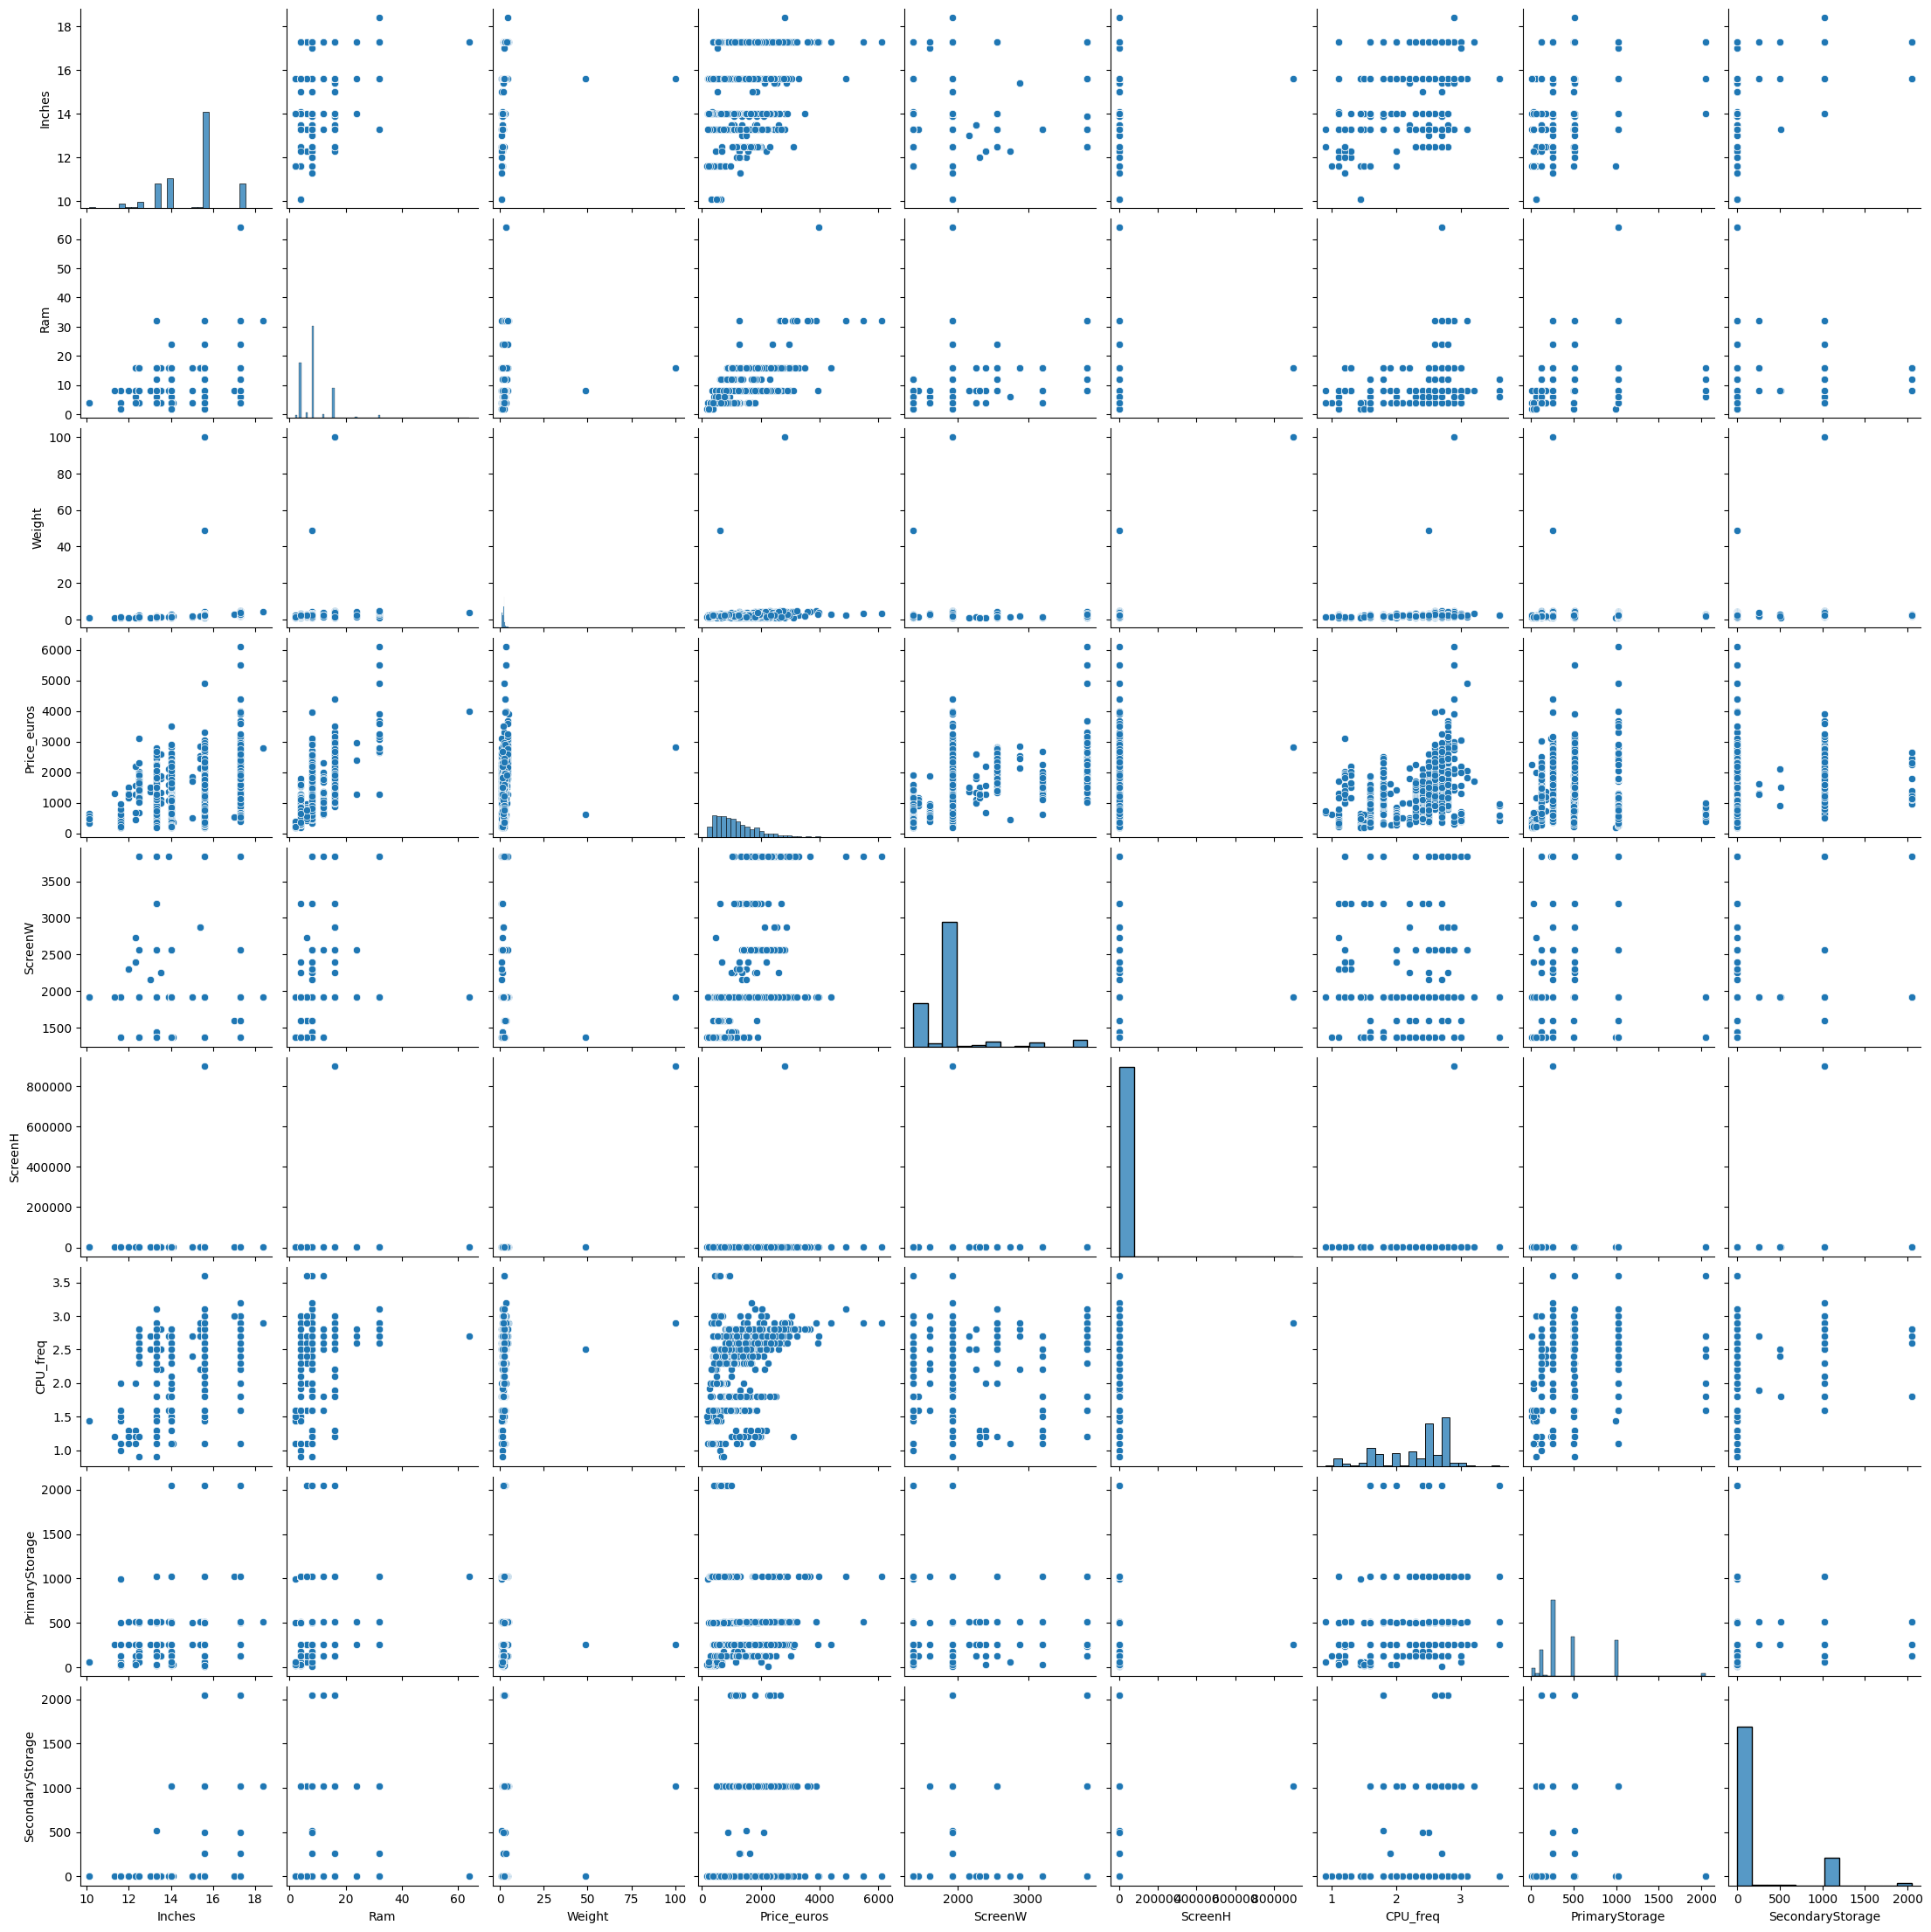

In [274]:
sns.pairplot(df_laptops)

## Task 2 - Classification of Student Success

### Dataload
Load the csv

In [275]:

# # Load your dataset
url = 'https://raw.githubusercontent.com/wortcook/UMKC/refs/heads/main/Fall2024/CS5530-0005/proj/student_dropout_academic_success.csv'
s = requests.get(url).content
df_student = pd.read_csv(io.StringIO(s.decode('utf-8')))
df_student.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5.0,171.0,1.0,1.0,122.0,1.0,19.0,12.0,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1.0,9254.0,1.0,1.0,160.0,1.0,1.0,3.0,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5.0,9070.0,1.0,1.0,122.0,1.0,37.0,37.0,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2.0,9773.0,1.0,1.0,122.0,1.0,38.0,37.0,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1.0,8014.0,0.0,1.0,100.0,1.0,37.0,38.0,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## Task 3 - Clustering of Apartments for Rent

### Dataload
Load the csv

In [276]:

# # Load your dataset
url = 'https://raw.githubusercontent.com/wortcook/UMKC/refs/heads/main/Fall2024/CS5530-0005/proj/apartments_for_rent.csv'
s = requests.get(url).content
df_apartment = pd.read_csv(io.StringIO(s.decode('utf-8')))
df_apartment.head()

,id,bathrooms,bedrooms,fee,pets_allowed,price,price_type,square_feet,state,latitude,longitude
0,5.668640e+09,1.0,1.0,No,Cats,2195.0,Monthly,542.0,CA,33.8520,-118.3759
1,5.668640e+09,1.5,3.0,No,"Cats,Dogs",1250.0,Monthly,1500.0,VA,37.0867,-76.4941
2,5.668640e+09,2.0,3.0,No,NaN,1395.0,Monthly,1650.0,NC,35.8230,-78.6438
3,5.668640e+09,1.0,2.0,No,"Cats,Dogs",1600.0,Monthly,820.0,CA,38.3622,-121.9712
4,5.668639e+09,1.0,1.0,No,"Cats,Dogs",975.0,Monthly,624.0,NM,35.1038,-106.6110
